In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import requests
import json

# Get data

Read your personal API key

In [2]:
with open("../api_key", "r") as file:
    API_KEY = file.read()

In [21]:
# Define the API endpoint and parameters
url = "https://api.atmo-aura.fr/api/v1/valeurs/horaire"

data = pd.DataFrame()

for site_id in ["FR15038", "FR15043", "FR15053"]:
    params = {
        "api_token": API_KEY,
        "format": "json",
        "sites": site_id,
        "date_debut": "-2 years",
        "label_court_polluant": "PM2.5",
        "order_by_date": "asc",
    }

    # Make the GET request
    response = requests.get(url, params=params)

    response = json.loads(response.text)
    data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

    while response["links"]["next"] is not None:
        response = requests.get(response["links"]["next"])
        response = json.loads(response.text)
        data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d %H:%M:%S")
data["date"] = data["date"].dt.tz_localize(None)

In [20]:
data["mesure_id"].unique().reshape(-1, 1)

array([['FR15038_39_57_3_C1'],
       ['FR15038_39_11'],
       ['FR15043_39_57_4_C1'],
       ['FR15043_39_57_5_C1'],
       ['FR15043_39_11'],
       ['FR15043_39_57_3_C1']], dtype=object)

In [43]:
class site():
    def __init__(self, data, site_id):
        self.data = data[data["site_id"] == site_id]

        if self.data.empty:
            raise ValueError("No data available for this site")
        
        self.site_id = site_id

        self.reference_data = self.data[data["type_appareil_id"] == 11]
        self.reference_values = self.reference_data.loc[:, ["valeur", "date"]]

        self.microsensor_data = self.data[data["type_appareil_id"] == 57]
        self.microsensor_values = self.microsensor_data.loc[:, ["valeur", "date"]]

    def get_reference_data(self):
        return self.reference_data
    
    def get_microsensor_data(self):
        return self.microsensor_data
    
    def get_reference_values(self):
        return self.reference_values
    
    def get_microsensor_values(self):
        return self.microsensor_values
    
    def plot(self, ax = None, *, kwargs = {}):
        if ax is None:
            ax = plt.gca()

        x_ref = self.reference_values["date"]
        y_ref = self.reference_values["valeur"]

        x_micro = self.microsensor_values["date"]
        y_micro = self.microsensor_values["valeur"]

        ax.plot(x_ref, y_ref, label="Reference values")
        ax.plot(x_micro, y_micro, label="Microsensor values")
        ax.set_title(f"PM2.5 values for site {self.site_id}")
        ax.set_xlabel("Date")
        ax.set_ylabel("PM2.5 values (µg/m³)")
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend()
    
        return ax

In [32]:
site_id_dict = {
    "Saint Martin d'Hères": "FR15038",
    "Les Frenes": "FR15043",
    "Rocade Sud": "FR15053",
}

LF = site(data, site_id_dict["Les Frenes"])

C:\Users\rickl\AppData\Local\Temp\ipykernel_1052\2098266668.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.reference_data = self.data[data["type_appareil_id"] == 11]
C:\Users\rickl\AppData\Local\Temp\ipykernel_1052\2098266668.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.microsensor_data = self.data[data["type_appareil_id"] == 57]


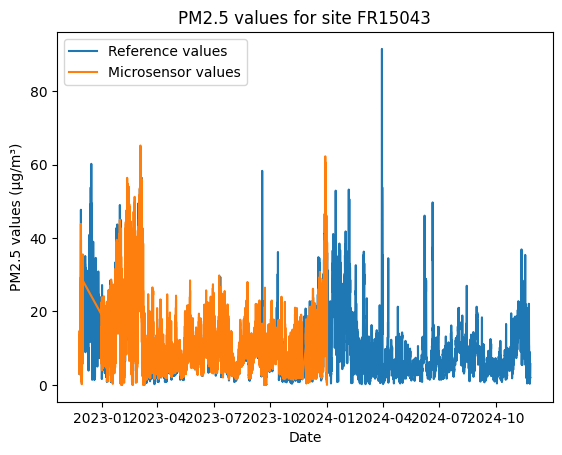

In [44]:
LF.plot()
plt.show()